In [107]:
import pandas as pd
import numpy as np
import simfin as sf
import seaborn as sns
import os
from dotenv import load_dotenv
import klib
import shap
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from simfin.names import *

# USE THIS FOR TICKER INFORMATION
import yfinance as yf

In [ ]:
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379
# https://github.com/skorch-dev/skorch

In [3]:
# def compare_feature_imp_corr(estimator, df, target_name):
#     """
#     Return a DataFrame which compares the signals' Feature
#     Importance in the Machine Learning model, to the absolute
#     correlation of the signals and stock-returns.
    
#     :param estimator: Sklearn ensemble estimator.
#     :return: Pandas DataFrame.
#     """
    
#     # Wrap the list of Feature Importance in a Pandas Series.
#     df_feat_imp = pd.Series(estimator.feature_importances_,
#                             index=df.drop(target_name, axis=1).columns,
#                             name='Feature Importance')

#     df_corr_returns = df.corrwith(df[target_name]).abs().sort_values(ascending=False).rename(f'{target_name} correlation')[1:]
    
#     # Concatenate the DataFrames with Feature Importance
#     # and Return Correlation.
#     dfs = [df_feat_imp, df_corr_returns]
#     df_compare = pd.concat(dfs, axis=1, sort=True)
    
#     # Sort by Feature Importance.
#     df_compare.sort_values(by='Feature Importance',
#                            ascending=False, inplace=True)
    
#     return df_compare

In [4]:
# use_cols = [
#     'SimFinId','Currency', 'Fiscal Year','Fiscal Period','Publish Date','Restated Date',
#     'Shares (Basic)','Shares (Diluted)','Revenue','Gross Profit','Operating Income (Loss)',
#     'Net Income','Cash, Cash Equivalents & Short Term Investments','Accounts & Notes Receivable',
#     'Long Term Debt','Total Liabilities','Retained Earnings','Change in Working Capital',
#     'Net Cash from Operating Activities','Net Cash from Investing Activities',
#     'Cash from (Repayment of) Debt','Cash from (Repurchase of) Equity',
#     'Net Cash from Financing Activities','Net Change in Cash','(Dividends + Share Buyback) / FCF',
#     'Asset Turnover','CapEx / (Depr + Amor)','Current Ratio','Dividends / FCF',
#     'Gross Profit Margin','Interest Coverage','Net Profit Margin','Quick Ratio',
#     'Return on Assets','Return on Equity','Share Buyback / FCF','Assets Growth',
#     'Assets Growth QOQ','Assets Growth YOY','Earnings Growth','Earnings Growth QOQ',
#     'Earnings Growth YOY','FCF Growth','FCF Growth QOQ','FCF Growth YOY',
#     'Sales Growth','Sales Growth QOQ','Sales Growth YOY','Free Cash Flow',
#     'Operating Margin','Free Cash Flow to Net Income','Liabilities to Equity Ratio',
#     'Earnings Per Share, Basic','Earnings Per Share, Diluted','Sales Per Share',
#     'Equity Per Share','Free Cash Flow Per Share'
# ]

In [5]:
# SETTINGS

# Set Pandas Options
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# Set your API-key for downloading data.
# If the API-key is 'free' then you will get the free data,
# otherwise you will get the data you have paid for.
# See www.simfin.com for what data is free and how to buy more.
load_dotenv()

SIMFIN_API_KEY = os.getenv('SIMFIN_API_KEY')
sf.set_api_key(SIMFIN_API_KEY)

# Set the local directory where data-files are stored.
# The dir will be created if it does not already exist.
sf.set_data_dir('simfin_data/')

In [6]:
# GOAL

# Determine Fair Market Value of Stock Price and the fundamental drivers that increase/decrease stock value

# STEPS
# 1. Pull Fundamental Data from simfin
#   a. Income Statement TTM (Trailing Twelve Month)
#   b. Balance Sheet TTM
#   c. Cash Flow TTM
#   d. Stock Price 
#   e. Sector/Industry
# 2. Merge Data using simfin helper function
#   a. https://github.com/SimFin/simfin-tutorials/blob/master/02_Resampling.ipynb
# 3. Create Percent Change Features for Fundamental Data (Not Stock Price) using the simfin helper function
#   a. https://github.com/SimFin/simfin-tutorials/blob/master/03_Growth_Returns.ipynb

In [7]:
# Load the annual Income Statements for all companies in USA.
# The data is automatically downloaded if you don't have it already.
# Quarterly Data is Needed for the Growth Signals Below
REFRESH_DAYS = 1

# GENERAL
income_df = sf.load_income(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
income_quarterly_df = sf.load_income(variant='quarterly', market='us', refresh_days=REFRESH_DAYS)

balance_df = sf.load_balance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
balance_quarterly_df = sf.load_balance(variant='quarterly', market='us', refresh_days=REFRESH_DAYS)

cashflow_df = sf.load_cashflow(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
cashflow_quarterlay_df = sf.load_cashflow(variant='quarterly', market='us', refresh_days=REFRESH_DAYS)

derived_df = sf.load_derived(variant='ttm', market='us', refresh_days=REFRESH_DAYS)

cache_args = {'cache_name': 'financial_signals',
              'cache_refresh' : 1}

fin_signal_df = sf.fin_signals(df_income_ttm=income_df,
                                df_balance_ttm=balance_df,
                                df_cashflow_ttm=cashflow_df,
                                **cache_args)

cache_args = {'cache_name': 'growth_signals',
              'cache_refresh' : 1}

growth_signal_df = sf.growth_signals(df_income_ttm=income_df,
                  df_income_qrt=income_quarterly_df,
                  df_balance_ttm=balance_df,
                  df_balance_qrt=balance_quarterly_df,
                  df_cashflow_ttm=cashflow_df,
                  df_cashflow_qrt=cashflow_quarterlay_df,
                  **cache_args)

# BANKS
income_banks_df = sf.load_income_banks(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
balance_banks_df = sf.load_balance_banks(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
cashflow_banks_df = sf.load_cashflow_banks(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
derived_banks_df = sf.load_derived_banks(variant='ttm', market='us', refresh_days=REFRESH_DAYS)

#INSURANCE
income_insurance_df = sf.load_income_insurance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
balance_insurance_df = sf.load_balance_insurance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
cashflow_insurance_df = sf.load_cashflow_insurance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
derived_insurance_df = sf.load_derived_insurance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)

# Shared
shareprices_df = sf.load_shareprices(variant='daily', market='us', refresh_days=REFRESH_DAYS)
company_df = sf.load_companies(market='us')
industry_df = sf.load_industries()

Dataset "us-income-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-derived-ttm" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-financial_signals.pickle' on disk (1 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-growth_signals.pickle' on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-income-banks-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-banks-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-banks-ttm" on disk (0 days old).
- Loading from disk 

In [8]:
# General
# Remove Columns that exist in other Fundamental DataFrames
balance_columns = balance_df.columns[~balance_df.columns.isin(set().union(income_df.columns))]
cashflow_columns = cashflow_df.columns[~cashflow_df.columns.isin(set().union(income_df.columns))]
derived_df_columns = derived_df.columns[~derived_df.columns.isin(set().union(income_df.columns, 
                                                                             growth_signal_df.columns, 
                                                                             fin_signal_df.columns))]

# Merge the fundamental data into a single dataframe
fundamental_df = income_df.join(balance_df[balance_columns]
                               ).join(cashflow_df[cashflow_columns]
                                     ).join(fin_signal_df
                                           ).join(growth_signal_df
                                                 ).join(derived_df[derived_df_columns])


# Banks
# Remove Columns that exist in other Fundamental DataFrames
balance_columns = balance_banks_df.columns[~balance_banks_df.columns.isin(set().union(income_banks_df.columns))]
cashflow_columns = cashflow_banks_df.columns[~cashflow_banks_df.columns.isin(set().union(income_banks_df.columns))]
derived_df_columns = derived_banks_df.columns[~derived_banks_df.columns.isin(set().union(income_banks_df.columns))]

# Merge the fundamental data into a single dataframe
fundamental_banks_df = income_banks_df.join(balance_banks_df[balance_columns]
                               ).join(cashflow_banks_df[cashflow_columns]
                                     ).join(derived_banks_df[derived_df_columns])

# Insurance
# Remove Columns that exist in other Fundamental DataFrames
balance_columns = balance_insurance_df.columns[~balance_insurance_df.columns.isin(set().union(income_insurance_df.columns))]
cashflow_columns = cashflow_insurance_df.columns[~cashflow_insurance_df.columns.isin(set().union(income_insurance_df.columns))]
derived_df_columns = derived_insurance_df.columns[~derived_insurance_df.columns.isin(set().union(income_insurance_df.columns))]

# Merge the fundamental data into a single dataframe
fundamental_insurance_df = income_insurance_df.join(balance_insurance_df[balance_columns]
                               ).join(cashflow_insurance_df[cashflow_columns]
                                     ).join(derived_insurance_df[derived_df_columns])

In [9]:
# fundamental_df = fundamental_df[use_cols]
# fundamental_banks_df = fundamental_banks_df[use_cols]
# fundamental_insurance_df = fundamental_insurance_df[use_cols]

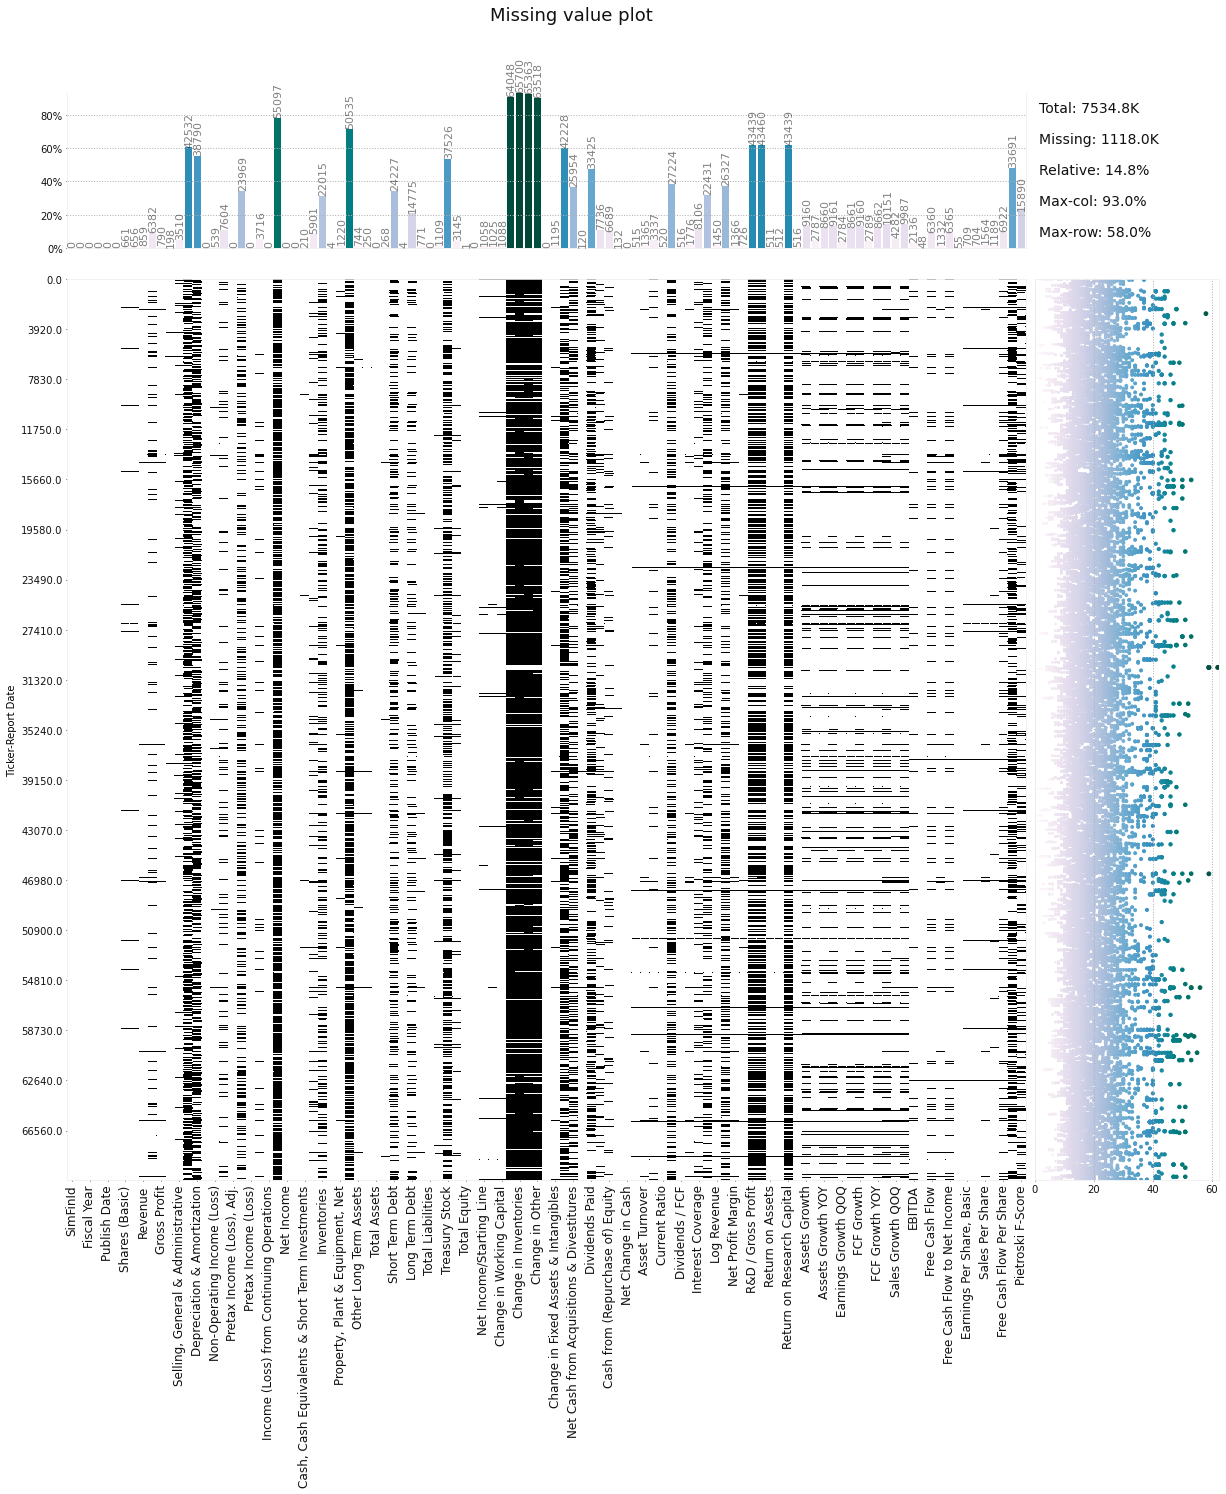

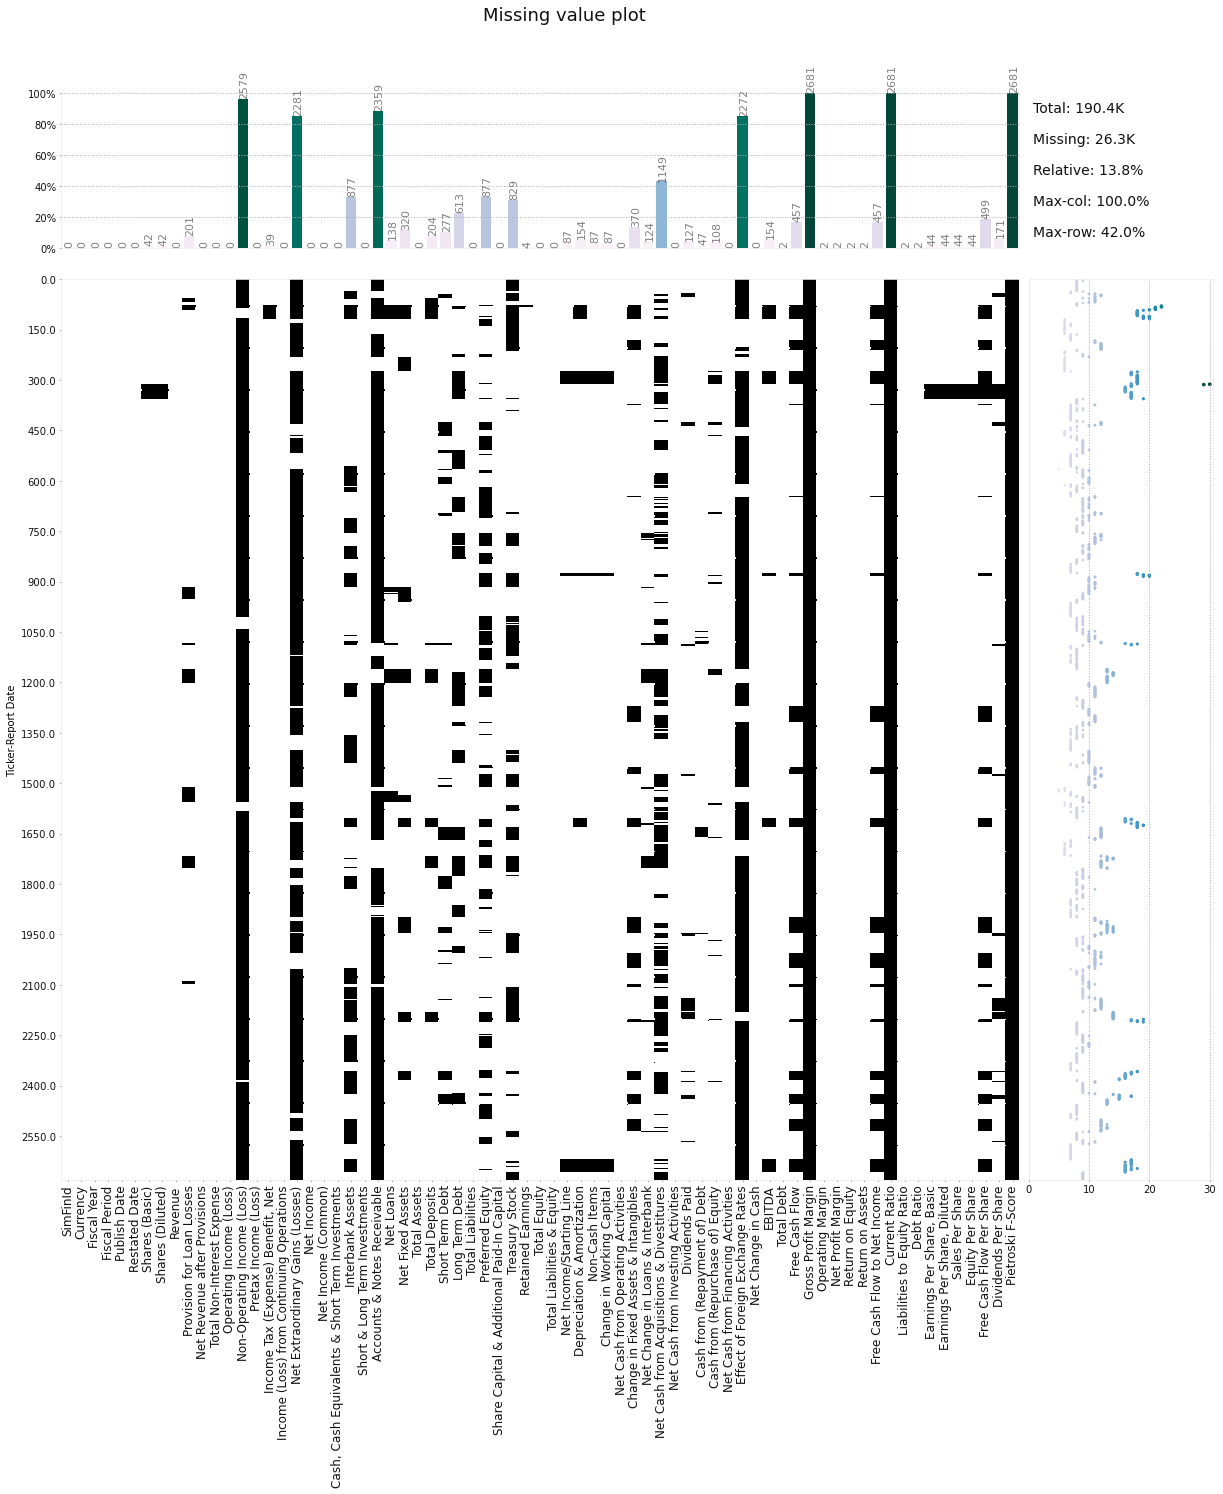

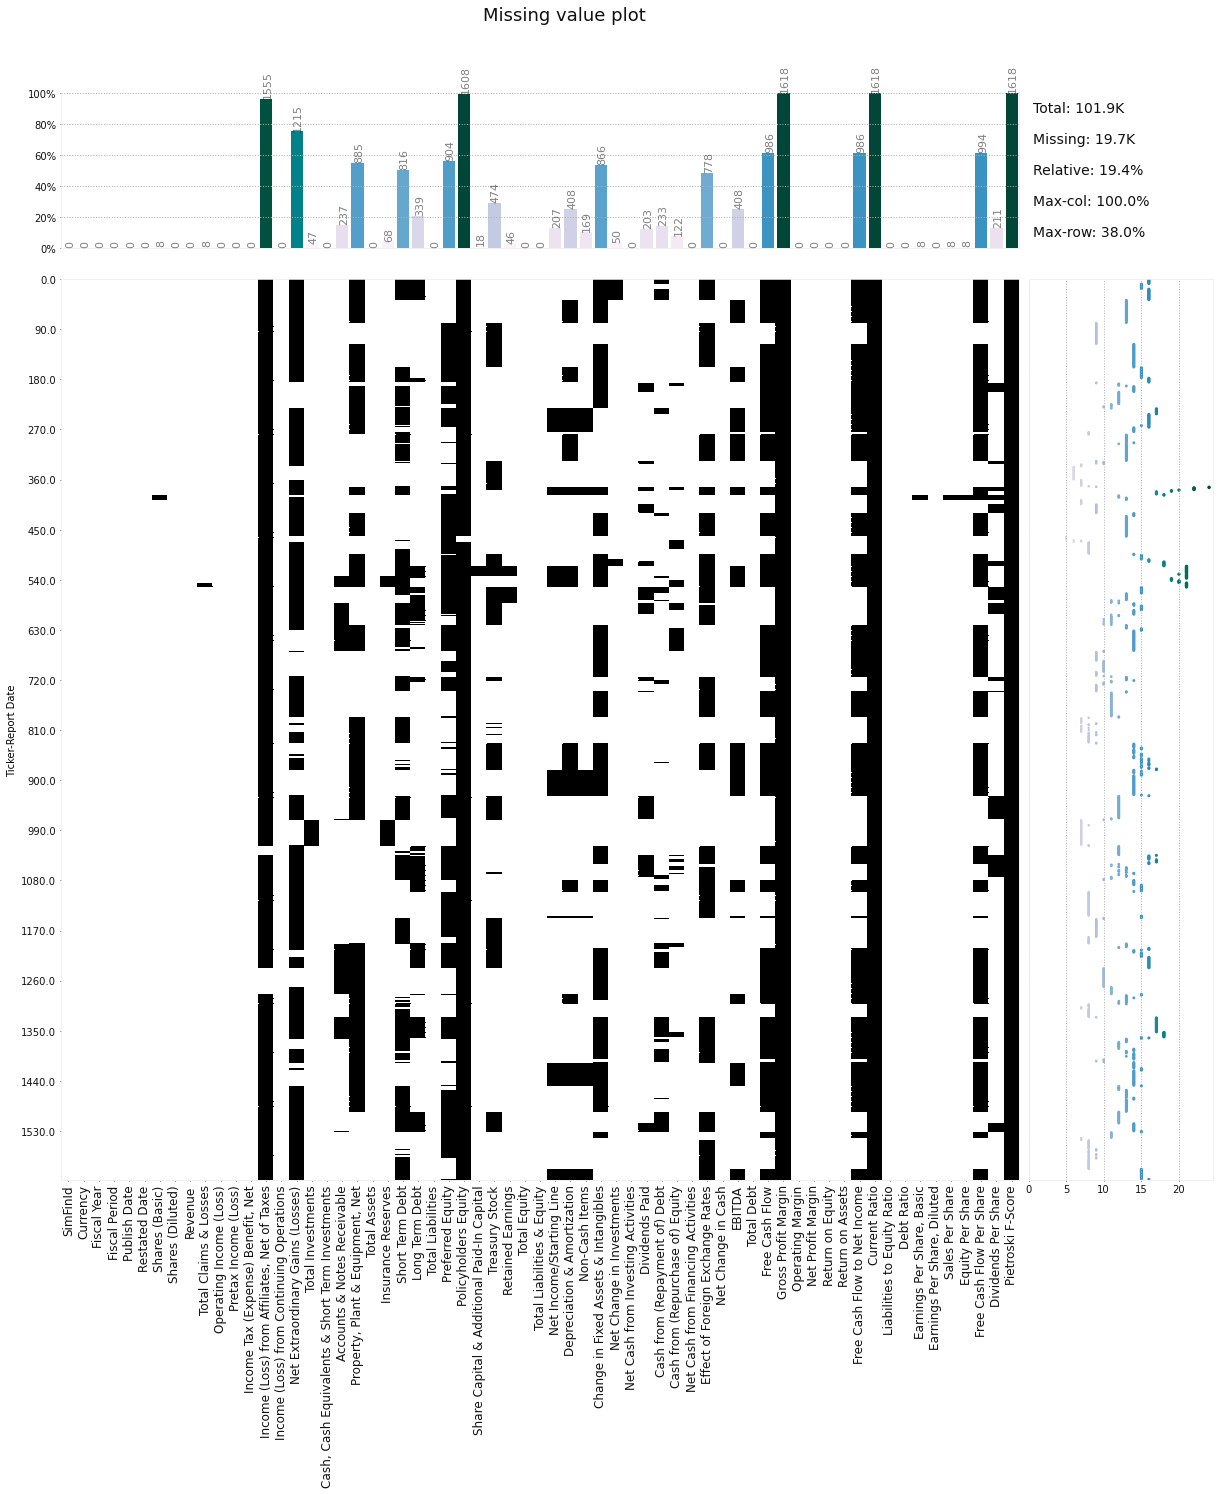

In [10]:
klib.missingval_plot(fundamental_df);
klib.missingval_plot(fundamental_banks_df);
klib.missingval_plot(fundamental_insurance_df);

In [11]:
# Drop Columns with more then 1-thresh nan values
thresh=0.7
fundamental_df = fundamental_df.dropna(thresh=int(thresh*len(fundamental_df)), axis=1)
fundamental_banks_df = fundamental_banks_df.dropna(thresh=int(thresh*len(fundamental_banks_df)), axis=1)
fundamental_insurance_df = fundamental_insurance_df.dropna(thresh=int(thresh*len(fundamental_insurance_df)), axis=1)

In [12]:
# Drop Duplicate Index
fundamental_df = fundamental_df[~fundamental_df.index.duplicated(keep='first')]
fundamental_banks_df = fundamental_banks_df[~fundamental_banks_df.index.duplicated(keep='first')]
fundamental_insurance_df = fundamental_insurance_df[~fundamental_insurance_df.index.duplicated(keep='first')]

In [13]:
# Replace Report Date with the Publish Date because the Publish Date is when the Fundamentals are known to the Public 
fundamental_df['Published Date'] = fundamental_df['Publish Date'] 
fundamental_df = fundamental_df.reset_index().set_index(['Ticker','Publish Date'])

fundamental_banks_df['Published Date'] = fundamental_banks_df['Publish Date'] 
fundamental_banks_df = fundamental_banks_df.reset_index().set_index(['Ticker','Publish Date'])

fundamental_insurance_df['Published Date'] = fundamental_insurance_df['Publish Date'] 
fundamental_insurance_df = fundamental_insurance_df.reset_index().set_index(['Ticker','Publish Date'])

In [242]:
# Merge Fundamental with Stock Prices

# downsample share prices to monthly
shareprices_df = sf.resample(df=shareprices_df[['Close']], rule='M', method='mean')

general_df = sf.reindex(df_src=fundamental_df, df_target=shareprices_df, group_index=TICKER, method='ffill'
               ).dropna(how='all').join(shareprices_df)

banks_df = sf.reindex(df_src=fundamental_banks_df, df_target=shareprices_df, group_index=TICKER, method='ffill'
               ).dropna(how='all').join(shareprices_df)

insurance_df = sf.reindex(df_src=fundamental_insurance_df, df_target=shareprices_df, group_index=TICKER, method='ffill'
               ).dropna(how='all').join(shareprices_df)

In [243]:
# # Add Company Attributes
# company_df = company_df.merge(industry_df, left_on='IndustryId', right_index=True, how='left', validate='many_to_one')
# df = df.reset_index().merge(company_df, on='SimFinId', how='left', validate='many_to_one').set_index(['Ticker', 'Date'])

In [244]:
# General
# Clean Up
general_df = general_df.drop(['SimFinId', 'Currency', 'Fiscal Year', 'Report Date', 'Restated Date', 'Fiscal Period', 'Published Date'], axis=1)
# general_df = general_df[general_df['Close'] <= general_df.loc['AMZN']['Close'].max()] # Remove Share Prices Over Amazon Share Price
general_df = general_df.dropna(subset=['Shares (Basic)', 'Shares (Diluted)', 'Revenue', 'Earnings Growth'])
general_df = general_df.replace([np.inf, -np.inf], 0)
general_df = general_df.fillna(0)

# Banks
# Clean Up
banks_df = banks_df.drop(['SimFinId', 'Currency', 'Fiscal Year', 'Report Date', 'Restated Date', 'Fiscal Period', 'Published Date'], axis=1)
banks_df = banks_df.dropna(subset=['Shares (Basic)', 'Shares (Diluted)', 'Revenue'])
banks_df = banks_df.replace([np.inf, -np.inf], 0)
banks_df = banks_df.fillna(0)

# Insurance
# Clean Up
insurance_df = insurance_df.drop(['SimFinId', 'Currency', 'Fiscal Year', 'Report Date', 'Restated Date', 'Fiscal Period', 'Published Date'], axis=1)
insurance_df = insurance_df.dropna(subset=['Shares (Basic)', 'Shares (Diluted)', 'Revenue']) # Drop Missing Sector/Industry Data
insurance_df = insurance_df.replace([np.inf, -np.inf], 0)
insurance_df = insurance_df.fillna(0)

In [245]:
# General
# Calculate Fundamental Data as per share
non_per_share_cols = ['Currency', 'Fiscal Year', 'Fiscal Period', 'Published Date',
                      'Restated Date', 'Shares (Basic)', 'Shares (Diluted)', 'Close',
                      ] + fin_signal_df.columns.tolist() + growth_signal_df.columns.tolist() + derived_df_columns.difference([ 'EBITDA', 'Total Debt', 'Free Cash Flow']).tolist() 

per_share_cols = general_df.columns[~general_df.columns.isin(non_per_share_cols)]

general_df[per_share_cols] =  general_df[per_share_cols].div(general_df['Shares (Diluted)'], axis=0)

# Banks
# Calculate Fundamental Data as per share
non_per_share_cols = ['Currency', 'Fiscal Year', 'Fiscal Period', 'Published Date',
                      'Restated Date', 'Shares (Basic)', 'Shares (Diluted)', 'Close',
                      ] + derived_df_columns.difference([ 'EBITDA', 'Total Debt', 'Free Cash Flow']).tolist() 

per_share_cols = banks_df.columns[~banks_df.columns.isin(non_per_share_cols)]

banks_df[per_share_cols] =  banks_df[per_share_cols].div(banks_df['Shares (Diluted)'], axis=0)

# Insurance
# Calculate Fundamental Data as per share
non_per_share_cols = ['Currency', 'Fiscal Year', 'Fiscal Period', 'Published Date',
                      'Restated Date', 'Shares (Basic)', 'Shares (Diluted)', 'Close',
                      ] + derived_df_columns.difference([ 'EBITDA', 'Total Debt', 'Free Cash Flow']).tolist() 

per_share_cols = insurance_df.columns[~insurance_df.columns.isin(non_per_share_cols)]

banks_df[per_share_cols] =  insurance_df[per_share_cols].div(insurance_df['Shares (Diluted)'], axis=0)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


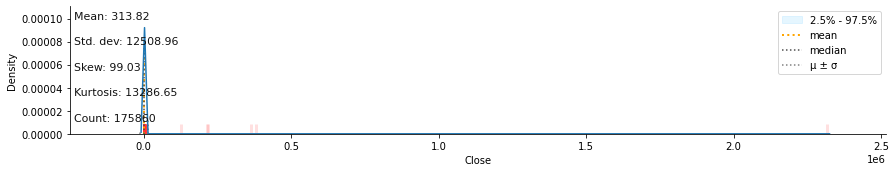

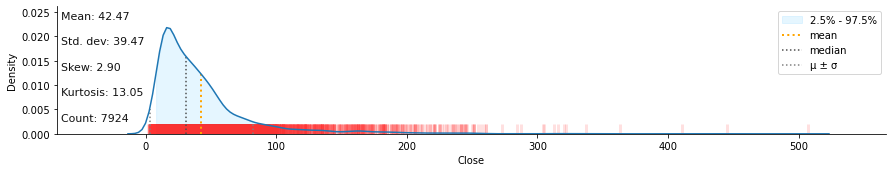

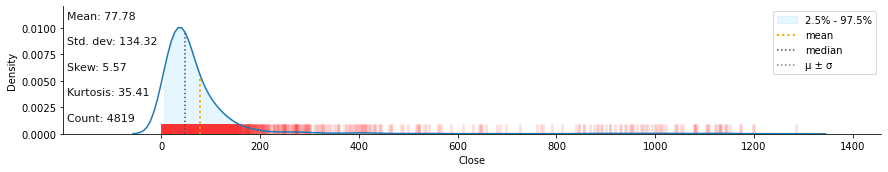

In [246]:
klib.dist_plot(general_df.Close);
klib.dist_plot(banks_df.Close);
klib.dist_plot(insurance_df.Close);

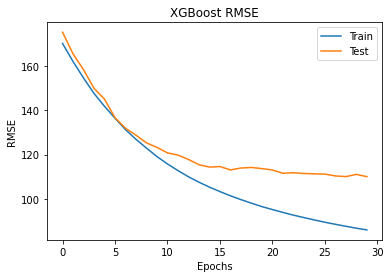

            R2 Score   RMSE
Train/Test                 
Train           0.74  85.84
Test            0.62 109.97
All             0.70  93.71


Feature Importance


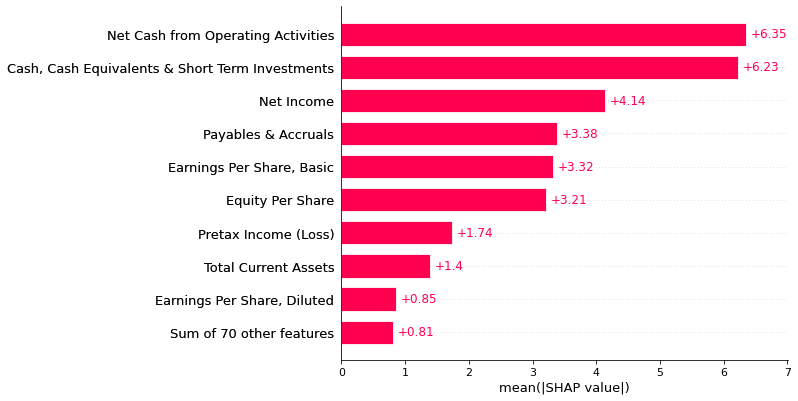

In [283]:
# General

# List of all unique stock-tickers in the dataset.
tickers = general_df.reset_index()[TICKER].unique()
tickers_train, tickers_test = train_test_split(tickers, train_size=0.70, random_state=25)

general_winsorize_df = sf.winsorize(general_df, clip=True, columns=['Close'], quantile=0.002)

train = general_winsorize_df.loc[tickers_train]
test = general_winsorize_df.loc[tickers_test]

# DataFrames with signals for training- and test-sets.
X = general_winsorize_df.drop(columns=['Close'])
X_train = train.drop(columns=['Close'])
X_test = test.drop(columns=['Close'])

# DataFrames with stock-returns for training- and test-sets.
y = general_winsorize_df['Close']
y_train = train['Close']
y_test = test['Close']

# Model Building
model = XGBRegressor(learning_rate=0.1, 
                     max_depth=1,
                     subsample=1,
                     colsample_bylevel=0.7,
                     colsample_bytree=0.7,
                     n_estimators=30) 

# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# retrieve performance metrics
results = model.evals_result()
results_df = pd.DataFrame([pd.Series(results['validation_0']['rmse'], name='Train'),
                           pd.Series(results['validation_1']['rmse'], name='Test')]).T

sns.lineplot(data=results_df, dashes=False)
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost RMSE')
plt.show()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = model.predict(X)

data = {
    'Train/Test':['Train', 'Test', 'All'],
    'R2 Score':[],
    'RMSE':[]
}

data['R2 Score'].append(r2_score(y_train, y_train_pred))
data['R2 Score'].append(r2_score(y_test, y_test_pred))
data['R2 Score'].append(r2_score(y, y_pred))

data['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y, y_pred)))

print(pd.DataFrame(data).set_index('Train/Test'))

# Shap Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
print('\n\nFeature Importance')
shap.plots.bar(shap_values, max_display=10)

In [281]:
general_winsorize_df.loc['AMZN'].tail()

,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income,Net Income (Common),"Cash, Cash Equivalents & Short Term Investments",Accounts & Notes Receivable,Total Current Assets,"Property, Plant & Equipment, Net",Other Long Term Assets,Total Noncurrent Assets,Total Assets,Payables & Accruals,Total Current Liabilities,Long Term Debt,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Retained Earnings,Total Equity,Total Liabilities & Equity,Net Income/Starting Line,Non-Cash Items,Change in Working Capital,Net Cash from Operating Activities,Change in Fixed Assets & Intangibles,Net Cash from Investing Activities,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,(Dividends + Share Buyback) / FCF,Asset Turnover,CapEx / (Depr + Amor),Current Ratio,Dividends / FCF,Gross Profit Margin,Interest Coverage,Log Revenue,Net Profit Margin,Quick Ratio,Return on Assets,Return on Equity,Share Buyback / FCF,Assets Growth,Assets Growth QOQ,Assets Growth YOY,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY,EBITDA,Total Debt,Free Cash Flow,Operating Margin,Free Cash Flow to Net Income,Liabilities to Equity Ratio,"Earnings Per Share, Basic","Earnings Per Share, Diluted",Sales Per Share,Equity Per Share,Free Cash Flow Per Share,Pietroski F-Score,Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-31,"499,000,000.00","508,500,000.00",684.26,-409.05,275.21,-236.07,-52.88,39.15,1.10,-2.01,40.25,40.25,-6.06,34.17,34.17,34.17,134.52,40.97,222.16,196.62,136.14,332.76,554.92,182.22,200.42,64.76,191.72,392.14,79.28,89.14,162.78,554.92,14.55,9.31,-3.91,52.08,-52.56,-67.87,2.06,2.43,2.06,-12.47,0.00,1.23,1.64,1.11,0.00,0.40,19.46,11.54,0.05,0.88,0.06,0.21,0.00,0.42,0.09,0.42,0.53,0.21,1.97,-1.01,-0.97,-0.72,0.31,0.08,0.37,71.27,64.76,20.86,0.06,0.61,2.41,34.82,34.17,697.29,165.88,21.26,5.00,"3,003.50"
2020-11-30,"499,000,000.00","508,500,000.00",684.26,-409.05,275.21,-236.07,-52.88,39.15,1.10,-2.01,40.25,40.25,-6.06,34.17,34.17,34.17,134.52,40.97,222.16,196.62,136.14,332.76,554.92,182.22,200.42,64.76,191.72,392.14,79.28,89.14,162.78,554.92,14.55,9.31,-3.91,52.08,-52.56,-67.87,2.06,2.43,2.06,-12.47,0.00,1.23,1.64,1.11,0.00,0.40,19.46,11.54,0.05,0.88,0.06,0.21,0.00,0.42,0.09,0.42,0.53,0.21,1.97,-1.01,-0.97,-0.72,0.31,0.08,0.37,71.27,64.76,20.86,0.06,0.61,2.41,34.82,34.17,697.29,165.88,21.26,5.00,"3,003.50"
2020-12-31,"499,000,000.00","508,500,000.00",684.26,-409.05,275.21,-236.07,-52.88,39.15,1.10,-2.01,40.25,40.25,-6.06,34.17,34.17,34.17,134.52,40.97,222.16,196.62,136.14,332.76,554.92,182.22,200.42,64.76,191.72,392.14,79.28,89.14,162.78,554.92,14.55,9.31,-3.91,52.08,-52.56,-67.87,2.06,2.43,2.06,-12.47,0.00,1.23,1.64,1.11,0.00,0.40,19.46,11.54,0.05,0.88,0.06,0.21,0.00,0.42,0.09,0.42,0.53,0.21,1.97,-1.01,-0.97,-0.72,0.31,0.08,0.37,71.27,64.76,20.86,0.06,0.61,2.41,34.82,34.17,697.29,165.88,21.26,5.00,"3,003.50"
2021-01-31,"499,000,000.00","508,500,000.00",684.26,-409.05,275.21,-236.07,-52.88,39.15,1.10,-2.01,40.25,40.25,-6.06,34.17,34.17,34.17,134.52,40.97,222.16,196.62,136.14,332.76,554.92,182.22,200.42,64.76,191.72,392.14,79.28,89.14,162.78,554.92,14.55,9.31,-3.91,52.08,-52.56,-67.87,2.06,2.43,2.06,-12.47,0.00,1.23,1.64,1.11,0.00,0.40,19.46,11.54,0.05,0.88,0.06,0.21,0.00,0.42,0.09,0.42,0.53,0.21,1.97,-1.01,-0.97,-0.72,0.31,0.08,0.37,71.27,64.76,20.86,0.06,0.61,2.41,34.82,34.17,697.29,165.88,21.26,5.00,"3,003.50"
2021-02-28,"500,000,000.00","510,000,000.00",756.99,-457.46,299.52,-254.62,-56.23,44.90,2.51,-2.14,47.41,47.41,-5.61,41.83,41.83,41.83,

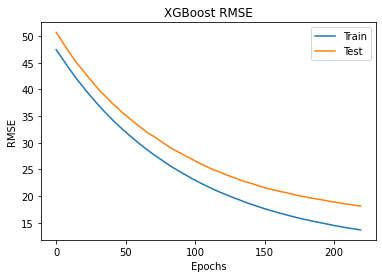

            R2 Score  RMSE
Train/Test                
Train           0.76 13.67
Test            0.67 18.15
All             0.72 15.64


Feature Importance


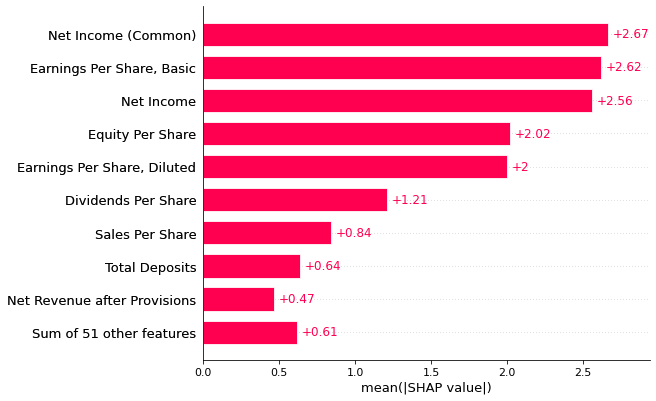

In [235]:
# Banks

# List of all unique stock-tickers in the dataset.
tickers = banks_df.reset_index()[TICKER].unique()
tickers_train, tickers_test = train_test_split(tickers, train_size=0.60, random_state=69420)

banks_winsorize_df = sf.winsorize(banks_df, clip=True, columns=['Close'], quantile=0.05)

train = banks_winsorize_df.loc[tickers_train]
test = banks_winsorize_df.loc[tickers_test]

# DataFrames with signals for training- and test-sets.
X = banks_winsorize_df.drop(columns=['Close'])
X_train = train.drop(columns=['Close'])
X_test = test.drop(columns=['Close'])

# DataFrames with stock-returns for training- and test-sets.
y = banks_winsorize_df['Close']
y_train = train['Close']
y_test = test['Close']

# Model Building

model = XGBRegressor(learning_rate=0.01, 
                     max_depth=1,
                     subsample=.2,
                     objective =  'reg:squarederror',
                     colsample_bylevel=0.5,
                     colsample_bytree=0.5,
                     reg_lambda=0.1,
                     n_estimators=220) 

# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# retrieve performance metrics
results = model.evals_result()
results_df = pd.DataFrame([pd.Series(results['validation_0']['rmse'], name='Train'),
                           pd.Series(results['validation_1']['rmse'], name='Test')]).T

sns.lineplot(data=results_df, dashes=False)
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost RMSE')
plt.show()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = model.predict(X)

data = {
    'Train/Test':['Train', 'Test', 'All'],
    'R2 Score':[],
    'RMSE':[]
}

data['R2 Score'].append(r2_score(y_train, y_train_pred))
data['R2 Score'].append(r2_score(y_test, y_test_pred))
data['R2 Score'].append(r2_score(y, y_pred))

data['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y, y_pred)))

print(pd.DataFrame(data).set_index('Train/Test'))

# Shap Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
print('\n\nFeature Importance')
shap.plots.bar(shap_values, max_display=10)

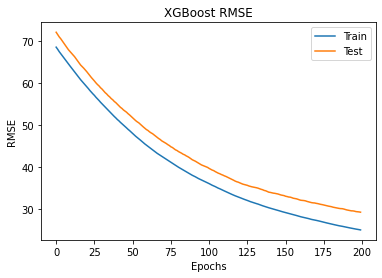

            R2 Score   RMSE
Train/Test                 
Train           0.66  24.98
Test            0.43  29.21
All             0.08 128.75


Feature Importance


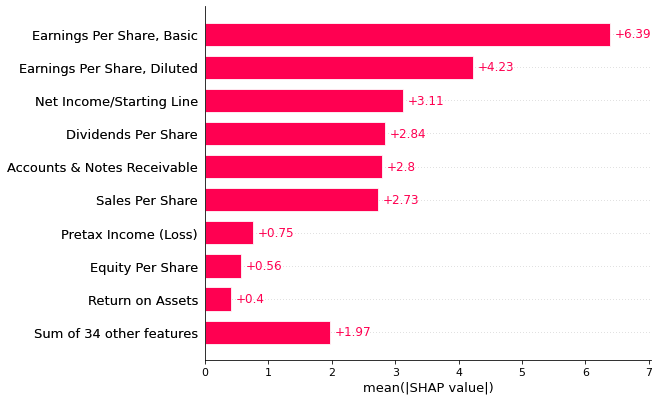

In [232]:
# Insurance

# List of all unique stock-tickers in the dataset.
tickers = insurance_df.reset_index()[TICKER].unique()
tickers_train, tickers_test = train_test_split(tickers, train_size=0.60, random_state=69420)

insurance_winsorize_df = sf.winsorize(insurance_df, clip=True, columns=['Close'], quantile=0.08)

train = insurance_winsorize_df.loc[tickers_train]
test = insurance_winsorize_df.loc[tickers_test]

# DataFrames with signals for training- and test-sets.

X = insurance_winsorize_df.drop(columns=['Close'])
X_train = train.drop(columns=['Close'])
X_test = test.drop(columns=['Close'])

# DataFrames with stock-returns for training- and test-sets.
y = insurance_df['Close']
y_train = train['Close']
y_test = test['Close']

# Model Building

model = XGBRegressor(learning_rate=0.01, 
                     max_depth=1,
                     subsample=1,
                     colsample_bylevel=0.5,
                     colsample_bytree=0.5,
                     reg_lambda=0.1,
                     n_estimators=200) 

# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# retrieve performance metrics
results = model.evals_result()
results_df = pd.DataFrame([pd.Series(results['validation_0']['rmse'], name='Train'),
                           pd.Series(results['validation_1']['rmse'], name='Test')]).T

sns.lineplot(data=results_df, dashes=False)
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost RMSE')
plt.show()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = model.predict(X)

data = {
    'Train/Test':['Train', 'Test', 'All'],
    'R2 Score':[],
    'RMSE':[]
}

data['R2 Score'].append(r2_score(y_train, y_train_pred))
data['R2 Score'].append(r2_score(y_test, y_test_pred))
data['R2 Score'].append(r2_score(y, y_pred))

data['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y, y_pred)))

print(pd.DataFrame(data).set_index('Train/Test'))

# Shap Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
print('\n\nFeature Importance')
shap.plots.bar(shap_values, max_display=10)

In [ ]:
model.fit(X, y)
y_pred = model.predict(X)

In [ ]:
pred_df = pd.concat([y.reset_index(), 
                     pd.Series(y_pred, name='Fundamental Close')
                    ], axis=1)

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid")
sns.scatterplot(data=sf.winsorize(pred_df[['Ticker', 'Close', 'Fundamental Close']].groupby(
    'Ticker').mean(), clip=False, quantile=.005), x='Close', y='Fundamental Close');

print(f"Correlation: {pred_df[['Ticker', 'Close', 'Fundamental Close']].groupby('Ticker').mean().corr().values[0][1]}")

In [ ]:
sns.set_style("whitegrid")
data = pred_df[pred_df.Ticker == 'CTL'].set_index('Date').drop('Ticker', axis=1)
sns.lineplot(data=data);

In [ ]:
explainer = shap.TreeExplainer(model)

max_date = X.index.get_level_values(1).max()

shap_values = explainer(X.loc[(slice('CTL','CTL'), slice(max_date, max_date)),:])[0]

shap.waterfall_plot(shap_values)

In [ ]:
shap.plots.bar(shap_values, max_display=12)

In [ ]:
# ALL VALUES
shap_values = explainer(X)

shap.plots.bar(shap_values, max_display=20)

In [ ]:
from fastai import *

In [ ]:
ticker = 'TSLA'
test_months = 24

df_train = df.loc[ticker].iloc[:-test_months]
df_test = df.loc[ticker].iloc[len(df.loc[ticker])-test_months:]

# DataFrames with signals for training- and test-sets.
X = df.loc[ticker].drop(columns=['Close'])
X_train = df_train.drop(columns=['Close'])
X_test = df_test.drop(columns=['Close'])

# DataFrames with stock-returns for training- and test-sets.
y = df.loc[ticker]['Close']
y_train = df_train['Close']
y_test = df_test['Close']

In [ ]:
model =  MLPRegressor(
    hidden_layer_sizes=(10,),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


model.fit(X_train, y_train)

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = model.predict(X)

data = {
    'Train/Test':['Train', 'Test', 'All'],
    'R2 Score':[],
    'RMSE':[]
}

data['R2 Score'].append(r2_score(y_train, y_train_pred))
data['R2 Score'].append(r2_score(y_test, y_test_pred))
data['R2 Score'].append(r2_score(y, y_pred))

data['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y, y_pred)))

pd.DataFrame(data).set_index('Train/Test')

In [ ]:
pred_df = pd.concat([y.reset_index(), 
                     pd.Series(y_pred, name='Fundamental Close')
                    ], axis=1)

sns.scatterplot(data=pred_df[['Close', 'Fundamental Close']], x='Close', y='Fundamental Close');

print(f"Correlation: {pred_df[['Close', 'Fundamental Close']].corr().values[0][1]}")

In [ ]:
sns.set_style("whitegrid")
data = pred_df.set_index('Date')
sns.lineplot(data=data);

In [ ]:
pred_df

In [ ]:
X_test

In [ ]:
fundamental_df.loc['TSLA'].tail()

In [ ]:
pred_df['1 Year Change'] = pred_df.groupby(
    'Ticker')['Close'].pct_change(12).shift(-12)

pred_df['Perc of Close'] = pred_df['Pred Close'].div(pred_df['Close'])
pred_df = pred_df.dropna()


In [ ]:
pred_df

In [ ]:
(pred_df['Pred Close'] / pred_df['Close']) - 1

In [ ]:
from  matplotlib.ticker import PercentFormatter

g = sns.scatterplot(data=sf.winsorize(pred_df[['Perc of Close', '1 Year Change', 'Ticker']],
                                  quantile=.05, clip=False, exclude_columns=['Ticker']), x='Perc of Close', y='1 Year Change')


g.yaxis.set_major_formatter(PercentFormatter(1))
g.xaxis.set_major_formatter(PercentFormatter(1))

In [ ]:
pred_df[pred_df.Date == pred_df.Date.max()].sort_values(by='1 Year Change', ascending=False).head(50)